In [ ]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)
import pandas as pd
import skimage
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

Python version
3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0)


In [ ]:
data_dir = "C:\\Users\\mvams\\OneDrive\\Desktop\\Nanda Paper\\Execution\\New_Data"
train_dir = data_dir + "\\Train"
valid_dir = data_dir + "\\Test"

In [ ]:
train_datagen = ImageDataGenerator()

validation_datagen = ImageDataGenerator(
    validation_split=0.5
)
#DATA:
train_set = train_datagen.flow_from_directory(
          train_dir,
          target_size=(256,256),
          batch_size=32,
          seed=101, 
          shuffle=True,
          class_mode='categorical',
          )
test_set = validation_datagen.flow_from_directory(
          valid_dir,
          target_size=(256,256),
          batch_size=32,
          shuffle=False,
          # seed=101,
          class_mode='categorical',
          subset = "training")

validation_set = validation_datagen.flow_from_directory(
          valid_dir,
          target_size=(256,256),
          batch_size=32,
          shuffle=True,
          # seed=101,
          class_mode='categorical',
          subset = "validation")

Found 11418 images belonging to 12 classes.
Found 1121 images belonging to 12 classes.
Found 1117 images belonging to 12 classes.


In [ ]:
diseases = os.listdir(train_dir)
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Alzheimer-MildDemented', 'Alzheimer-ModerateDemented', 'Alzheimer-NonDemented', 'Alzheimer-VeryMildDemented', 'Brain_Tumor-glioma_tumor', 'Brain_Tumor-glioma_tumor-meningioma_tumor', 'Brain_Tumor-glioma_tumor-pituitary_tumor', 'Healthy_Brain', 'Multiple Sclerosis-Control-Axial', 'Multiple Sclerosis-Control-Sagittal', 'Multiple Sclerosis-MS-Axial', 'Multiple Sclerosis-MS-Sagittal']
Total disease classes are: 12


In [ ]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Alzheimer-MildDemented,717
Alzheimer-ModerateDemented,52
Alzheimer-NonDemented,2560
Alzheimer-VeryMildDemented,1792
Brain_Tumor-glioma_tumor,826
Brain_Tumor-glioma_tumor-meningioma_tumor,822
Brain_Tumor-glioma_tumor-pituitary_tumor,827
Healthy_Brain,395
Multiple Sclerosis-Control-Axial,1002
Multiple Sclerosis-Control-Sagittal,1014


Text(0.5, 1.0, 'Images per each class of Brain disease')

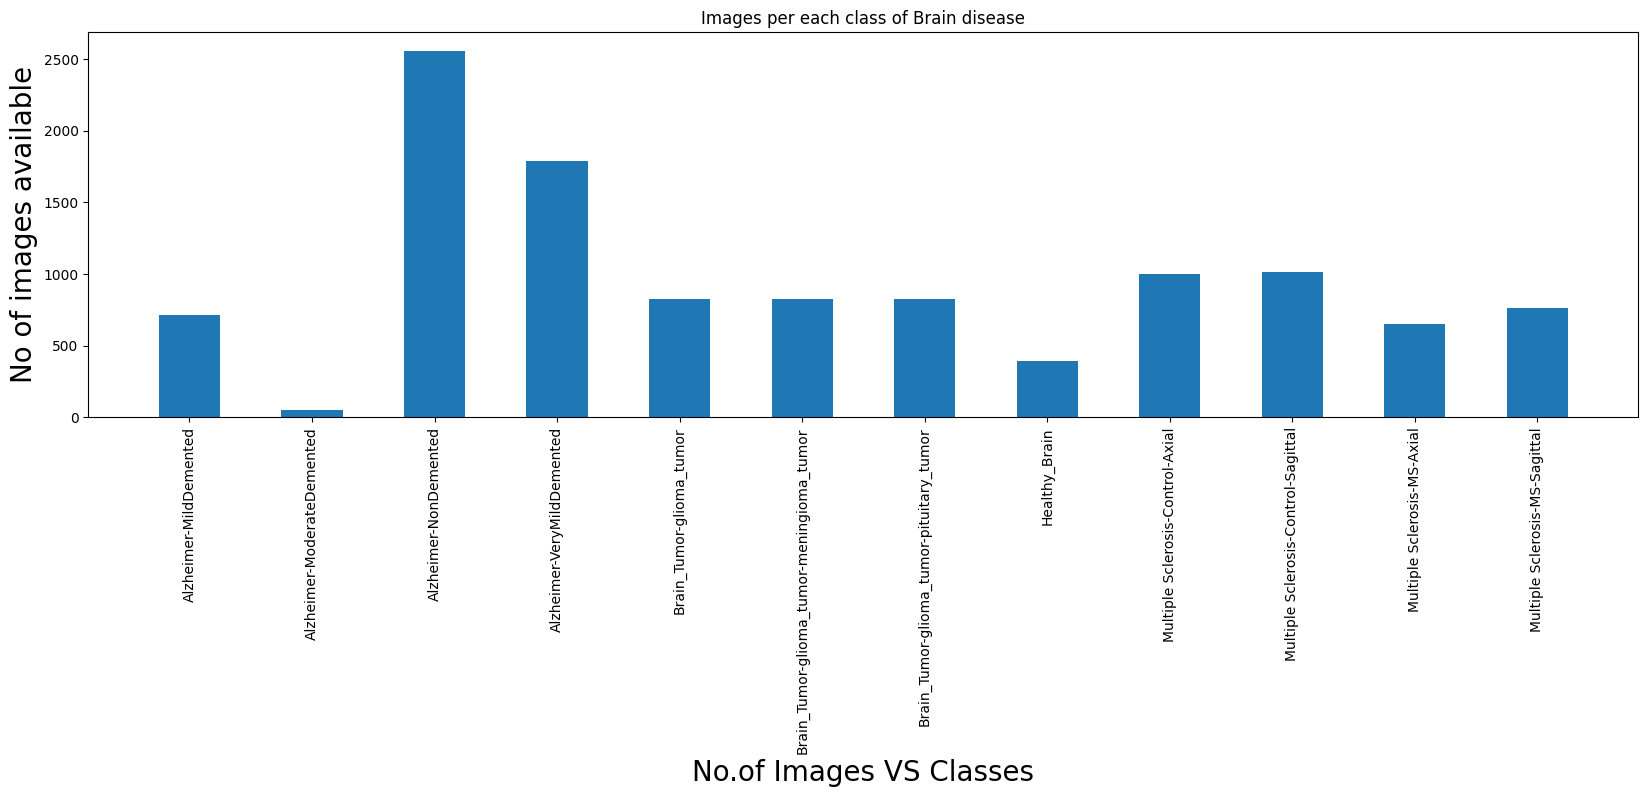

In [ ]:
# plotting number of images available for each disease
index = [n for n in range(12)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.5)
plt.xlabel('No.of Images VS Classes', fontsize=20)
plt.ylabel('No of images available', fontsize=20)
plt.xticks(index, diseases, fontsize=10, rotation=90)
plt.title('Images per each class of Brain disease')

In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 11418 images for training


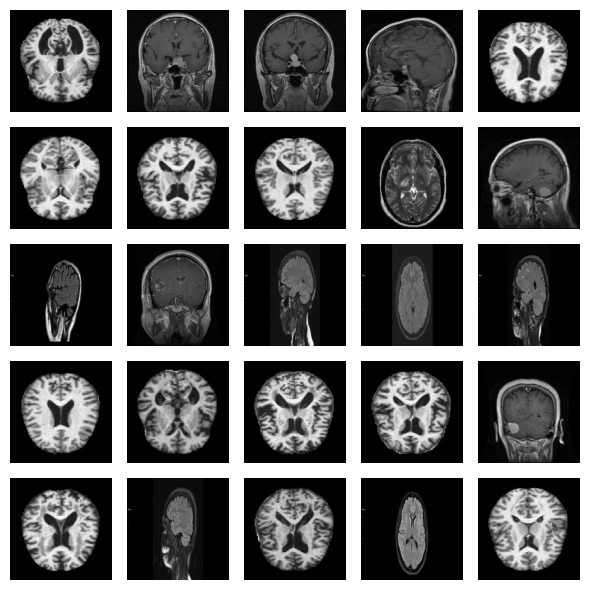

In [ ]:
# This function will plot images in the form of a grid with 5 row and 5 columns where images are placed in each column.
sample_training_images, _ = next(train_set)
def plotImages(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(6,6))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
      
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images)

In [ ]:
from tensorflow.keras.models import Sequential
!pip install tensorflow_addons
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Softmax,Conv2D,MaxPooling2D,BatchNormalization,Activation
from tensorflow_addons.optimizers import CyclicalLearningRate
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add,SeparableConv2D
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

C:\Users\mvams\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
@tf.autograph.experimental.do_not_convert
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = SeparableConv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.swish(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.swish(x)
        return out

@tf.autograph.experimental.do_not_convert
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (3, 3), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        # out = tf.nn.swish(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


In [ ]:
model = ResNet18(12)
model.build(input_shape = (None,256,256,3))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
model.summary()

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  42176     
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 42176     
 )                                                               
                                                         

In [ ]:
cyclical_learning_rate = CyclicalLearningRate(
 initial_learning_rate=3e-7,
 maximal_learning_rate=0.001,
 step_size=len(train_set),
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

optimizer = tf.keras.optimizers.Adam(learning_rate = cyclical_learning_rate, clipvalue=0.1)
                                 
model.compile(loss="categorical_crossentropy",
                  optimizer =optimizer, metrics=["accuracy"])

In [ ]:
path = "C:\\Users\\mvams\\OneDrive\\Desktop\\Nanda Paper\\Execution\\Models"
checkpoint_filepath = path  + 'weights.{epoch:02d}-{val_accuracy:.2f}.tf'
model_checkpoint_callback = [
    tf.keras.callbacks.ModelCheckpoint(
                                      filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,save_format='tf' ) 
    ,

    tf.keras.callbacks.EarlyStopping(
                                  monitor='val_accuracy', min_delta=0,
                                  patience=15, verbose=2, mode='auto',
                                  baseline=None, restore_best_weights=True)
    ,
    # tf.keras.callbacks.ReduceLROnPlateau(
    #                                       monitor="val_accuracy",factor=0.1,
    #                                       patience=10,verbose=0,mode="auto",
    #                                      min_delta=0.0001,cooldown=0,min_lr=0,)
    ]


In [ ]:
tf.random.set_seed(7)
history = model.fit(x = train_set, validation_data = validation_set,epochs = 10,batch_size=32 , callbacks=[model_checkpoint_callback])

Epoch 1/10
357/357 [==============================] - 216s 555ms/step - loss: 1.0133 - accuracy: 0.5899 - val_loss: 2.4028 - val_accuracy: 0.1549


C:\Users\mvams\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/10
357/357 [==============================] - 122s 340ms/step - loss: 0.3696 - accuracy: 0.8580 - val_loss: 0.8022 - val_accuracy: 0.7556


C:\Users\mvams\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/10
357/357 [==============================] - 89s 247ms/step - loss: 0.1342 - accuracy: 0.9542 - val_loss: 0.8740 - val_accuracy: 0.7323
Epoch 4/10
357/357 [==============================] - 109s 306ms/step - loss: 0.0821 - accuracy: 0.9728 - val_loss: 0.9425 - val_accuracy: 0.7959


C:\Users\mvams\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 5/10
357/357 [==============================] - 133s 372ms/step - loss: 0.0213 - accuracy: 0.9955 - val_loss: 0.8342 - val_accuracy: 0.8048


C:\Users\mvams\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 6/10
357/357 [==============================] - 127s 357ms/step - loss: 0.0119 - accuracy: 0.9971 - val_loss: 0.8956 - val_accuracy: 0.8165


C:\Users\mvams\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 7/10
357/357 [==============================] - 215s 604ms/step - loss: 0.0047 - accuracy: 0.9999 - val_loss: 0.9157 - val_accuracy: 0.8084
Epoch 8/10
357/357 [==============================] - 131s 365ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.9369 - val_accuracy: 0.8075
Epoch 9/10
357/357 [==============================] - 102s 285ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.8842 - val_accuracy: 0.8165
Epoch 10/10
357/357 [==============================] - 105s 293ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.9135 - val_accuracy: 0.8138


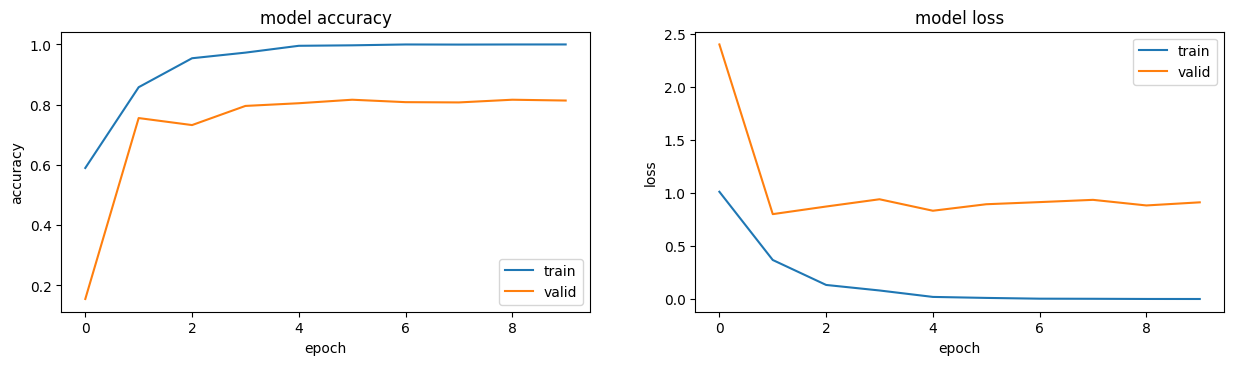

In [ ]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

In [ ]:
loss,acc = model.evaluate(test_set)

36/36 [==============================] - 7s 196ms/step - loss: 1.4318 - accuracy: 0.6949
